In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3  # Changed to B3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Directories
train_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\train'
val_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\val'
test_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test'

In [3]:
# Image dimensions and batch size
IMAGE_SIZE = (300, 300)  # B3 default input size is 300x300
BATCH_SIZE = 8

# Random augmentation function
def random_augmentation(image):
    if np.random.rand() < 0.5:
        image = tf.image.random_flip_left_right(image)
    if np.random.rand() < 0.5:
        image = tf.image.random_flip_up_down(image)
    if np.random.rand() < 0.5:
        image = tf.image.random_brightness(image, max_delta=0.2)
    if np.random.rand() < 0.5:
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    return image

In [4]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=random_augmentation
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 12137 images belonging to 7 classes.
Found 3474 images belonging to 7 classes.
Found 1737 images belonging to 7 classes.


In [5]:
# Get the number of classes from the generator
NUM_CLASSES = len(train_generator.class_indices)

# Learning rate logger callback
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        print(f"Epoch {epoch + 1}: Learning Rate: {lr:.6f}, Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}")

In [6]:
# Build EfficientNetB3 model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # Use dynamic number of classes

model = Model(inputs=base_model.input, outputs=predictions)

# First freeze the base model
base_model.trainable = False

# Initial compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback instance
lr_logger = LearningRateLogger()

# Initial training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[lr_logger]
)

Epoch 1/5
1518/1518 [==============================] - 325s 194ms/step - loss: 1.9352 - accuracy: 0.1785 - val_loss: 1.9061 - val_accuracy: 0.2001
Epoch 2/5
1518/1518 [==============================] - 217s 143ms/step - loss: 1.9209 - accuracy: 0.1835 - val_loss: 1.9136 - val_accuracy: 0.1972
Epoch 3/5
1518/1518 [==============================] - 198s 130ms/step - loss: 1.9118 - accuracy: 0.1886 - val_loss: 1.8914 - val_accuracy: 0.2093
Epoch 4/5
1518/1518 [==============================] - 241s 159ms/step - loss: 1.9104 - accuracy: 0.1894 - val_loss: 1.8879 - val_accuracy: 0.1998
Epoch 5/5
1518/1518 [==============================] - 256s 168ms/step - loss: 1.9090 - accuracy: 0.1898 - val_loss: 1.8776 - val_accuracy: 0.2081


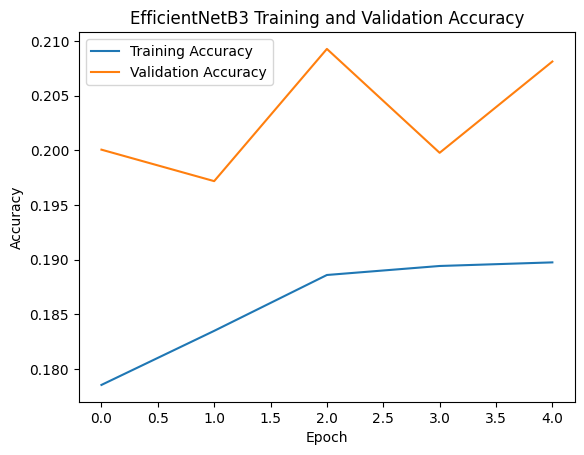

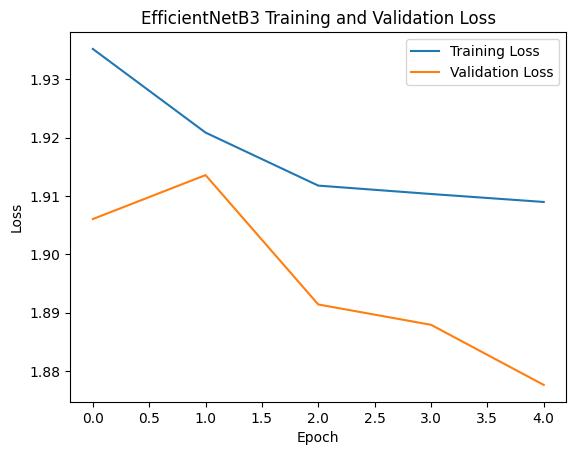

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetB3 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB3 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# Fine-tuning: Unfreeze the base model
base_model.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning training
history_fine_tune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[lr_logger]
)

Epoch 1/5
1518/1518 [==============================] - 386s 247ms/step - loss: 1.4421 - accuracy: 0.4857 - val_loss: 0.9042 - val_accuracy: 0.7003
Epoch 2/5
1518/1518 [==============================] - 369s 243ms/step - loss: 0.8190 - accuracy: 0.7097 - val_loss: 0.6079 - val_accuracy: 0.7968
Epoch 3/5
1518/1518 [==============================] - 358s 236ms/step - loss: 0.6303 - accuracy: 0.7774 - val_loss: 0.5006 - val_accuracy: 0.8284
Epoch 4/5
1518/1518 [==============================] - 353s 233ms/step - loss: 0.5043 - accuracy: 0.8249 - val_loss: 0.3347 - val_accuracy: 0.8918
Epoch 5/5
1518/1518 [==============================] - 378s 249ms/step - loss: 0.4440 - accuracy: 0.8455 - val_loss: 0.3594 - val_accuracy: 0.8851


In [10]:
tf.keras.backend.clear_session()

In [12]:
model.save(r'D:\CADT\CapstoneProjectI\ml__model\models\efficientnetb3.h5')

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [14]:
# Save the model in SavedModel format
saved_model_path = r'D:\CADT\CapstoneProjectI\ml__model\models\efficientnetb3_savedmodel'
tf.saved_model.save(model, saved_model_path)
print(f"Model saved in SavedModel format to {saved_model_path}")

INFO:tensorflow:Assets written to: D:\CADT\CapstoneProjectI\ml__model\models\efficientnetb3_savedmodel\assets


INFO:tensorflow:Assets written to: D:\CADT\CapstoneProjectI\ml__model\models\efficientnetb3_savedmodel\assets


Model saved in SavedModel format to D:\CADT\CapstoneProjectI\ml__model\models\efficientnetb3_savedmodel


In [15]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history_fine_tune.history_fine_tune['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tune.history_fine_tune['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetB3 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history_fine_tune.history_fine_tune['loss'], label='Training Loss')
plt.plot(history_fine_tune.history_fine_tune['val_loss'], label='Validation Loss')
plt.title('EfficientNetB3 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

AttributeError: 'History' object has no attribute 'history_fine_tune'

NameError: name 'history_fine_tune' is not defined

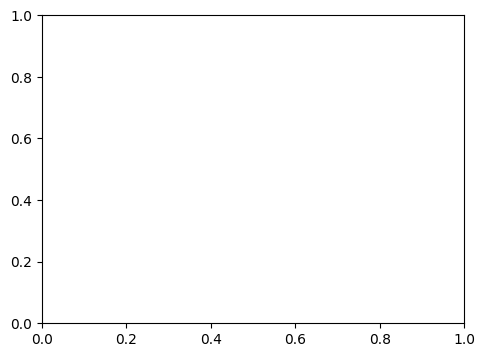

In [20]:
# Visualization
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine_tune.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine_tune.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + history_fine_tune.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Found 1737 images belonging to 7 classes.
55/55 [==============================] - 27s 457ms/step


<Figure size 1000x800 with 0 Axes>

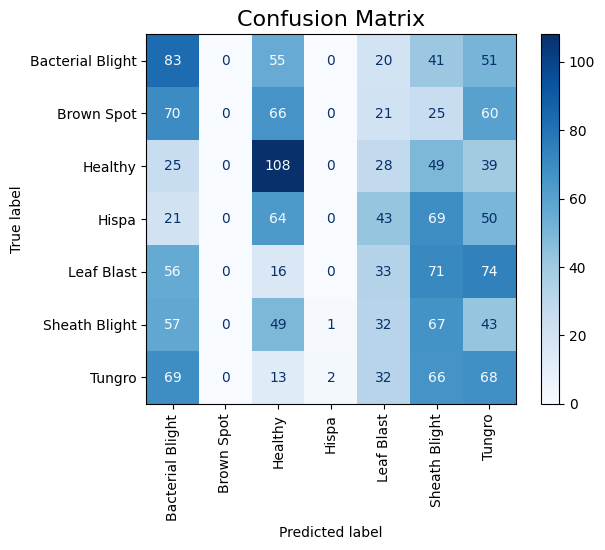

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the test data
test_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for correct label ordering
)

# Get true labels from the 'test_ds' directory iterator
true_labels = test_ds.classes  # True labels

# Assuming 'model' is already trained
pred_probs = model.predict(test_ds)
pred_labels = np.argmax(pred_probs, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Display the confusion matrix
class_labels = list(test_ds.class_indices.keys())  # Get class labels from the generator
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

plt.title('Confusion Matrix', fontsize=16)
plt.show()

Found 1737 images belonging to 7 classes.
55/55 [==============================] - 13s 231ms/step


C:\Users\Hak Sou\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hak Sou\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hak Sou\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

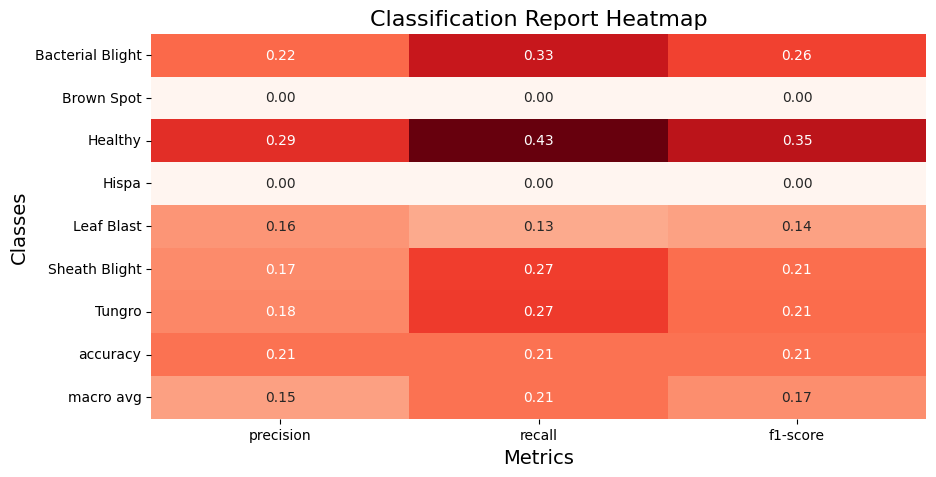

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the test data
test_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for correct label ordering
)

# Get true labels from the 'test_ds' directory iterator
true_labels = test_ds.classes  # True labels

# Assuming 'model' is already trained
pred_probs = model.predict(test_ds)
pred_labels = np.argmax(pred_probs, axis=1)  # Convert probabilities to class labels

# Generate a classification report
report = classification_report(true_labels, pred_labels, target_names=list(test_ds.class_indices.keys()), output_dict=True)

# Convert the report to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Plot the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap=plt.cm.Reds, fmt=".2f", cbar=False)
plt.title('Classification Report Heatmap', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Classes', fontsize=14)
plt.show()